# CO Freezeout 
Script to calculate the freeze-out from C18O 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
import astropy.constants as const

In [2]:
file_c180 = './data/c18o_mom0_reprojected.fits'
hdu_c180 = fits.open(file_c180)[0]
data_c180 = hdu_c180.data
header_c180 = hdu_c180.header

file_N_H2 = './data/coldense_H2.fits'
hdu_N_H2 = fits.open(file_N_H2)[0]
data_N_H2 = hdu_N_H2.data
header_N_H2 = hdu_N_H2.header

FileNotFoundError: [Errno 2] No such file or directory: './data/coldense_H2.fits'

In [ ]:
import numpy as np
import astropy.units as u
import astropy.constants as const

def compute_C18O_column_density_alt(W, T_ex=7.5*u.K, eta=1.0, f_clump=1.0):
    """
    Compute the C18O column density from the integrated intensity W (in K km/s)
    using the optically thin equation with explicit constants for the J=1-0 transition.
    
    The equation used is:
    
      dN_C18O/dv = 6.571e14 * [Q_rot / (f(T_ex) - f(T_bg)] 
                    * [1 - exp(-hν/(kT_ex))]^-1 * (T*_A/(η f_clump))
                    
      where f(T) = 1/(exp(hν/(kT)) - 1) and T_bg = 2.725 K.
      
    Then the total column density is given by:
    
      N_C18O = (dN_C18O/dv) * W.
    
    Parameters
    ----------
    W : astropy.units.Quantity
        Integrated intensity (T*_A) map in units of K km/s.
    T_ex : astropy.units.Quantity, optional
        Excitation temperature (default is 7.5 K).
    eta : float, optional
        Beam filling factor (default is 1.0).
    f_clump : float, optional
        Clump (beam dilution) factor (default is 1.0).
        
    Returns
    -------
    N_C18O : astropy.units.Quantity
        C18O column density in cm^-2.
    """
    # Physical constants in cgs units.
    h = const.h.cgs      # erg s
    k = const.k_B.cgs    # erg/K
    c = const.c.cgs      # cm/s

    # Frequency for C18O J=1-0.
    # Hernandez et al. (2011) quote hν/k = 5.269 K, so:
    nu = (5.269 * u.K * k / h).to(u.Hz)
    # Alternatively, one might use: nu = 109.782e9 * u.Hz

    # Einstein A coefficient for C18O J=1-0.
    A_ul = 6.266e-8 / u.s

    # Rotational constant for C18O.
    B = 5.4891e10 / u.s

    # Define f(T) = 1/(exp(hν/(kT)) - 1)
    def f_func(T):
        return 1.0 / (np.exp((h * nu / (k * T)).decompose().value) - 1)
    
    f_Tex = f_func(T_ex)
    f_Tbg = f_func(2.725 * u.K)
    
    # Compute the rotational partition function Q_rot by summing over J levels.
    # For a linear molecule: Q_rot = Σ_{J=0}^{J_max} (2J+1) exp[-J(J+1) hB/(kT_ex)].
    Q_rot = 0.0
    Jmax = 3  # summing up to J=3 is sufficient for T_ex ~ 7.5 K.
    for J in range(Jmax+1):
        exponent = -J*(J+1) * (h * B / (k * T_ex)).decompose().value
        Q_rot += (2*J + 1) * np.exp(exponent)
    Q_rot = Q_rot * u.dimensionless_unscaled

    # Now compute the column density per unit velocity using the optically thin formula:
    dNdv = (6.571e14 * u.cm**-2 / (u.K * u.km/u.s)) \
           * (Q_rot / (f_Tex - f_Tbg)) \
           * (1.0 / (1.0 - np.exp(- (h * nu / (k * T_ex)).decompose().value)))
    
    # Multiply by the integrated intensity (and account for eta and f_clump):
    N_C18O = dNdv * (W / (eta * f_clump))
    
    return N_C18O.decompose()

# --- Example usage ---

# Suppose you have an integrated intensity map (dummy example):
W_C18O = np.array([1]) * u.K * u.km/u.s

# Compute the C18O column density using the alternative function:
N_C18O_alt = compute_C18O_column_density_alt(W_C18O, T_ex=7.5*u.K, eta=1.0, f_clump=1.0)

print("C18O Column Density (cm^-2):")
print(N_C18O_alt)

In [3]:
import numpy as np
import astropy.units as u

def compute_C18O_column_density(W, eta=1):
    """
    Compute the C18O column density from the integrated intensity W (in K km/s)
    in the optically thin limit for the J=1-0 transition (Tex = 7.5 K),
    following Hernandez et al. (2011).

    Parameters
    ----------
    W : astropy.units.Quantity
        Integrated intensity map in units of K km/s.
    eta : float, optional
        Beam filling factor (default is 1).

    Returns
    -------
    N_C18O : astropy.units.Quantity
        C18O column density in cm^-2.
    """
    # The factor from Hernandez et al. (2011) for Tex = 7.5 K:
    factor = 9.758e14 * u.cm**-2 / (u.K * u.km/u.s)
    N_C18O = factor * (W / eta)
    return N_C18O

def convert_C18O_to_H2_column(N_C18O, X_C18O=6.12e-7):
    """
    Convert the C18O column density to an H2 column density using the
    assumed abundance ratio X_C18O = N(C18O)/N(H2).

    Parameters
    ----------
    N_C18O : astropy.units.Quantity
        C18O column density in cm^-2.
    X_C18O : float, optional
        Assumed abundance of C18O relative to H2 (default is 6.12e-7).

    Returns
    -------
    N_H2 : astropy.units.Quantity
        H2 column density in cm^-2.
    """
    N_H2 = N_C18O / X_C18O
    return N_H2

def compute_CO_depletion_factor(N_H2_ext, N_H2_CO):
    """
    Compute the CO depletion factor f_D, defined as the ratio of the 
    independent H2 column density (from, e.g., extinction mapping) to that 
    derived from the CO data.

    Parameters
    ----------
    N_H2_ext : astropy.units.Quantity
        H2 column density from an independent method (e.g., extinction) in cm^-2.
    N_H2_CO : astropy.units.Quantity
        H2 column density derived from C18O in cm^-2.

    Returns
    -------
    f_D : astropy.units.Quantity
        CO depletion factor (dimensionless).
    """
    return N_H2_ext / N_H2_CO

# --- Example usage ---

# Suppose you have a C18O J=1-0 integrated intensity map (dummy example):
W_C18O = data_c180 * u.K * u.km/u.s

# Compute the C18O column density:
N_C18O = compute_C18O_column_density(W_C18O, eta=1)

# Convert the C18O column density to an H2 column density using the abundance ratio.
#n16O/n18O = 327 from Wilson & Rood (1994) and n12CO/nH2 = 2×10−4 from Lacy et al. (1994).
N_H2_CO = convert_C18O_to_H2_column(N_C18O, X_C18O=6.12e-7)

# Suppose you have an independent H2 column density map (e.g., from extinction):
N_H2_ext = data_N_H2 * u.cm**-2

# Compute the depletion factor:
f_D = compute_CO_depletion_factor(N_H2_ext, N_H2_CO)

In [4]:
hdu_f_D = fits.PrimaryHDU(f_D.value, header=header_c180)
hdu_f_D.writeto('./data/f_D.fits', overwrite=True)

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_17465/1945690250.py:4: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(N_H2_ext.value.flatten()), bins=100, histtype='step', label='N_H2_ext')


Text(0, 0.5, 'N')

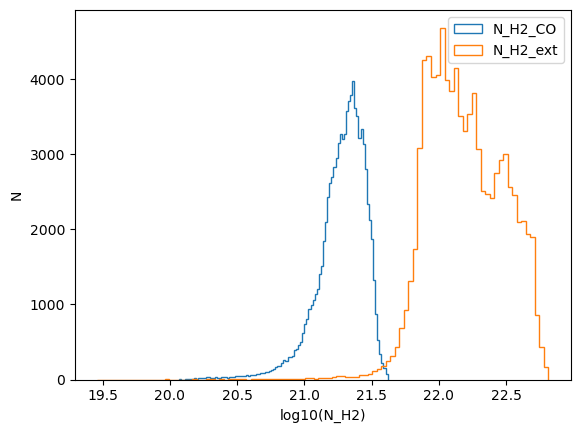

In [5]:
# plot hist of N_H2
plt.figure()
plt.hist(np.log10(N_H2_CO.value.flatten()), bins=100, histtype='step', label='N_H2_CO')
plt.hist(np.log10(N_H2_ext.value.flatten()), bins=100, histtype='step', label='N_H2_ext')
plt.legend()
plt.xlabel('log10(N_H2)')
plt.ylabel('N')

Text(0, 0.5, 'N')

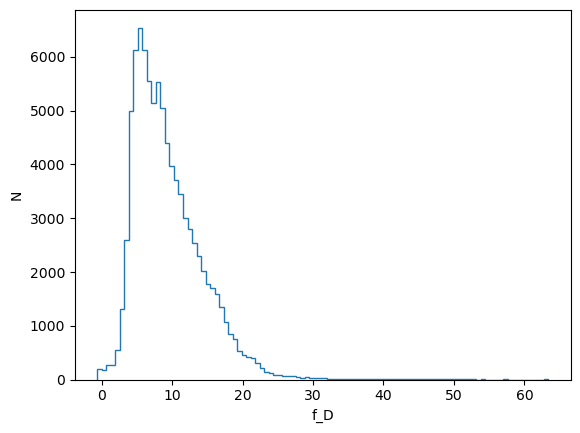

In [6]:
# plot hist of f_D
plt.figure()
plt.hist(f_D.value.flatten(), bins=100, histtype='step')
plt.xlabel('f_D')
plt.ylabel('N')